# SELECT COASTAL ICE FROM NSIDC-0051 #

This notebook walks through the code for selecting just coastal cells from the National Snow and Ice Data Centers Sea Ice Concentrations from Nimbus-7 SMMR and DMSP SSM/I-SSMIS Passive Microwave Data, Version 2 (DATA SET ID: NSIDC-0051 and DOI: 10.5067/MPYG15WAA4WX). The code uses xarray and dask and accesses the data through the NASA earthaccess data portal. The same process is used to find, access, filter,and download other datasets such as NSIDC-0081 and NSIDC-0079.

### Part One: Access the data ###

We start with importing the necessary libraries and authenticating earthaccess as show below.

In [1]:
import earthaccess
import xarray as xr
import dask
import numpy as np

In [ ]:
auth = earthaccess.login(strategy='interactive', persist = True)

We then uses the earthaccess API to collect a list of results. When this is run for a larger data analysis project we use dates ranging from 1980 to 2023 but here we just show the month of January, 2021. We spefify which dataset we want using the short name (NSIDC-0051), specify the data range, specify that we want spefifically data from the arctic and not antarctic, and specify data that is hosted on the cloud through earthdata.

We are returned 32 results even though there are just 31 days in January. This is because we also get a monthly average of sea ice in January, 2021.

In [ ]:
results = earthaccess.search_data(
    short_name='NSIDC-0051',
    temporal=('2021-01-01', '2021-01-31'),
    bounding_box=(-180, 0, 180, 90),
    cloud_hosted=True
)

print(f"here we found {len(results)} results")
results[31]

here we found 32 results


Collection: {'EntryTitle': 'Sea Ice Concentrations from Nimbus-7 SMMR and DMSP SSM/I-SSMIS Passive Microwave Data V002'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 179.02484, 'Latitude': 41.80504}, {'Longitude': -163.80127, 'Latitude': 50.96562}, {'Longitude': -138.71528, 'Latitude': 55.43137}, {'Longitude': -112.22181, 'Latitude': 52.76906}, {'Longitude': -92.8624, 'Latitude': 44.52438}, {'Longitude': -80.73977, 'Latitude': 33.92496}, {'Longitude': -70.77431, 'Latitude': 38.73699}, {'Longitude': -58.82606, 'Latitude': 42.0387}, {'Longitude': -45.53545, 'Latitude': 43.28017}, {'Longitude': -32.18801, 'Latitude': 42.21741}, {'Longitude': -20.10047, 'Latitude': 39.06067}, {'Longitude': -9.97205, 'Latitude': 34.34537}, {'Longitude': 2.11133, 'Latitude': 45.10754}, {'Longitude': 21.67858, 'Latitude': 53.53652}, {'Longitude': 48.81407, 'Latitude': 56.27585}, {'Longitude': 74.44231, 'Latitude': 51.68658}, {'Longitude': 91.72822, 'Latitude': 42.34026}, {'Longitude': 102.33908, 'Latitude': 31.36525}, {'Longitude': 111.9987, 'Latitude': 35.64846}, {'Longitude': 123.25126, 'Latitude': 38.47948}, {'Longitude': 135.48969, 'Latitude': 39.42506}, {'Longitude': 147.68426, 'Latitude': 38.32008}, {'Longitude': 158.82603, 'Latitude': 35.35642}, {'Longitude': 168.3497, 'Latitude': 30.98056}, {'Longitude': 179.02484, 'Latitude': 41.80504}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-01-31T00:00:00.000Z', 'EndingDateTime': '2021-01-31T23:59:59.999Z'}}
Size(MB): 0.0705462
Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/PM/NSIDC-0051/2/2021/01/31/NSIDC0051_SEAICE_PS_N25km_20210131_v2.0.nc']

We now can take our returned list of coastal ice data and use earth access's .open() function which will give us a list of file-like objects. For example files[0] returns https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/PM/NSIDC-0051/2/2021/01/01/NSIDC0051_SEAICE_PS_N25km_202101_v2.0.nc

This list of files is then converted into an XArray object using XArrays .open_mfdataset() functions with Dask parallel processing and combining by coordinates. This returns the dataset you can look through below. 

In [129]:
files = earthaccess.open(results)
ds = xr.open_mfdataset(files, parallel=True, combine='by_coords')
ds

QUEUEING TASKS | :   0%|          | 0/32 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/32 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/32 [00:00<?, ?it/s]

<xarray.Dataset> Size: 34MB
Dimensions:     (time: 31, y: 448, x: 304)
Coordinates:
  * x           (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y           (y) float64 4kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * time        (time) datetime64[ns] 248B 2021-01-01 2021-01-02 ... 2021-01-31
Data variables:
    crs         (time) |S1 31B b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    F17_ICECON  (time, y, x) float64 34MB dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
Attributes: (12/49)
    title:                     Sea Ice Concentrations from Nimbus-7 SMMR and ...
    summary:                   This data set is generated from brightness tem...
    id:                        10.5067/MPYG15WAA4WX
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced by the NASA Cryospheri...
    metadata_link:             https://doi.org/10.5067/MPYG15WAA4WX
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           v2.0
    source:                    Polar stereographic brightness temperatures fr...
    instrument:                SSMIS > Special Sensor Microwave Imager/Sounder
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...

### Part Two: Get Just Coastal Cells ###

The next section goes over the code to select just the cells that border coasts. We define this as being within 3 grid cells of a coast however the code can be easily changed. Lets start by importing some more libraries to help with this.

In [138]:
import geopandas as gpd
import cartopy.feature as cfeature
from rasterio import features
from scipy.ndimage import convolve
from rasterio.transform import from_origin

Next we import a 1:10m land raster which has been downloaded into the data folder of this repo. You can find that here https://www.naturalearthdata.com/downloads/10m-physical-vectors/ as well. Not we have to convert this to epsg 3411 (https://epsg.io/3411) which is NSIDC Sea Ice Polar Stereographic North and is the coordinate system our data uses.

In [139]:
land = gpd.read_file("../data/ne_10m_land/ne_10m_land.shp")
land = land.to_crs(epsg=3411)


Next we have to define our transform for rasterizing the data. Below we compute the spatial resolution and geographic origin of the grid and package it into a format needed to align spatial data correctly. 

These variables are specified in the metadata you can find in the previous section. The variables dx and dy are just the size of our grid cells (25,000) and the variables x0 and y0 represent the origin of the grid (-3837500.0 and -5337500.0 respectively). However we define these like this dx = float(ds.x.diff('x').mean()) instead of dx = 25,000 to be slightly more thorough for when this function is used for other datasets.

In [153]:
# dx = float(ds.x.diff('x').mean())
# dy = float(ds.y.diff('y').mean())
dx = 25000
dy = -25000
# x0 = float(ds.x.min())
# y0 = float(ds.y.min())
x0 = -3837500
y0 = -5337500

transform = [dx, 0, x0, 0, -dy, y0]


Next we use that tranform to rasterize the landmask and create a coastal mask. Finally we can convert that coastal mask to an XArray DataArray object and map it.

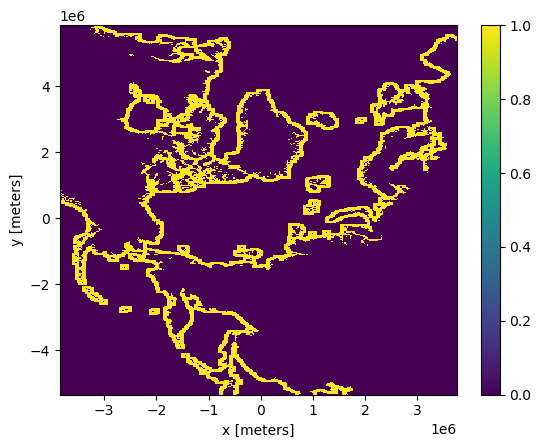

In [165]:
land_mask = features.rasterize(
    ((geom, 1) for geom in land.geometry),
    out_shape=(ds.sizes['y'], ds.sizes['x']),
    transform=transform,
    fill=0,
    dtype=np.uint8
)

# create coastal mask (within 3 grid cells of land)

ocean = (land_mask == 0).astype(int)
kernel = np.ones((7, 7))
land_neighbor_count = convolve(1 - ocean, kernel, mode='constant', cval=0)
coastal_mask = (ocean == 1) & (land_neighbor_count > 0)

# convert to xarray.DataArray

coastal_mask_xr = xr.DataArray(
    coastal_mask,
    coords={'y': ds.y, 'x': ds.x},
    dims=('y', 'x')
)

# map the coastal filter

import matplotlib.pyplot as plt

coastal_mask_xr.plot()

Finally here are the results when we apply that mask to a day in our dataset and plot that.

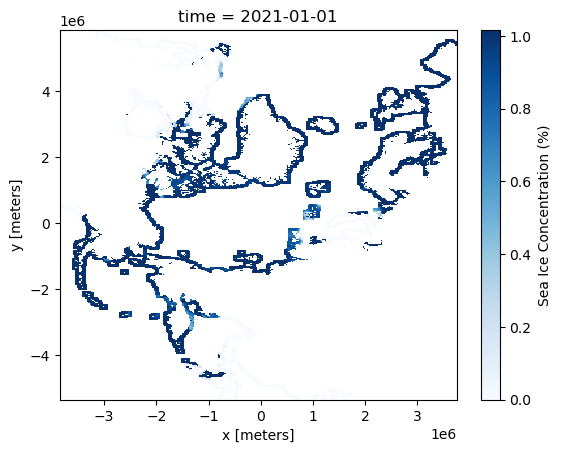

In [178]:
ds_masked = ds.where(coastal_mask_xr)
ds_masked.F17_ICECON.isel(time=0).plot(cmap='Blues', cbar_kwargs={'label': 'Sea Ice Concentration (%)'})

### Part Three: Everything Together

Now we can wrap everything into a function and use that in preprocessing when we download data. That would look something like this which as you can see returns the same results.

In [168]:
def select_coastal(ds):

    # load land polygons and reproject to EPSG:3411

    land = gpd.read_file("../data/ne_10m_land/ne_10m_land.shp")
    land = land.to_crs(epsg=3411)

    # get transform for rasterizing

    dx = float(ds.x.diff('x').mean())  # 25000 meters
    dy = float(ds.y.diff('y').mean())  # 25000 meters
    x0 = float(ds.x.min())
    y0 = float(ds.y.min())
    transform = [dx, 0, x0, 0, -dy, y0]

    # rasterize land mask: 1 = land, 0 = ocean

    land_mask = features.rasterize(
        ((geom, 1) for geom in land.geometry),
        out_shape=(ds.sizes['y'], ds.sizes['x']),
        transform=transform,
        fill=0,
        dtype=np.uint8
    )

    # create coastal mask (within 3 grid cells of land)

    ocean = (land_mask == 0).astype(int)
    kernel = np.ones((7, 7))  # 3-cell radius
    land_neighbor_count = convolve(1 - ocean, kernel, mode='constant', cval=0)
    coastal_mask = (ocean == 1) & (land_neighbor_count > 0)

    # convert to xarray.DataArray

    coastal_mask_xr = xr.DataArray(
        coastal_mask,
        coords={'y': ds.y, 'x': ds.x},
        dims=('y', 'x')
    )

    # apply mask

    return ds.where(coastal_mask_xr)


Here we do the same process as in section one we just pass select_coastal() into preprocessing.

QUEUEING TASKS | :   0%|          | 0/32 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/32 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/32 [00:00<?, ?it/s]

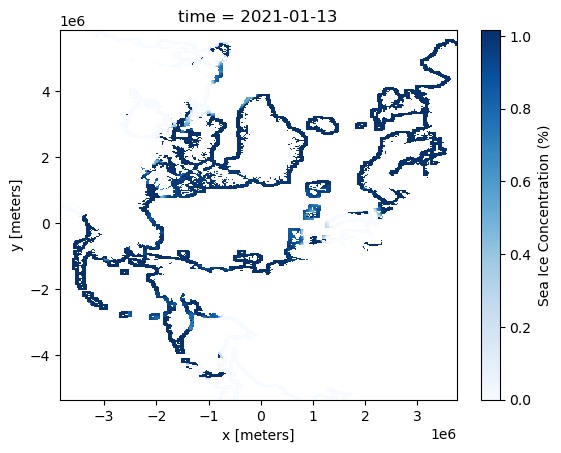

In [179]:
# get results in earthaccess

results = earthaccess.search_data(
    short_name='NSIDC-0051',
    temporal=('2021-01-01', '2021-01-31'),
    bounding_box=(-180, 0, 180, 90),
    cloud_hosted=True
)

# open results with xarray

files = earthaccess.open(results)
ds = xr.open_mfdataset(files, parallel=True, combine='by_coords', preprocess=select_coastal)
ds.F17_ICECON.isel(time=12).plot(cmap='Blues', cbar_kwargs={'label': 'Sea Ice Concentration (%)'})